# Notes
**Goal**: Explore image filters and restoration techniques using `scipy.ndimage` and `skimage`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import skimage
from scipy import ndimage 

import abc

In [33]:
from scipy import misc
import imageio ## @ PIL pillow

img_file = "test.png"

imageio.imsave( img_file, misc.face())
misc.face().tofile("test.raw")

In [129]:
def show_image(img_list, nc=2, cmap='gray'):    
    n = len(img_list)
    nr = n//nc + ( 0 if n%nc == 0 else 1) 
    for i, img in enumerate(img_list):
        plt.subplot(nr, nc, (i+1) )
        plt.imshow( img, cmap=cmap)
        plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show();
     
## Prioritize ndimage operations over skimage or the best of the two??
class AnImage:
    def __init__(self, src):
        self.img = skimage.color.rgb2gray(
            skimage.io.imread( src ) )
       
    def show(self, cmap='gray', binz=None):
        plt.subplot(1,2,1)
        plt.imshow(self.img, cmap=cmap)
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.hist(self.img.flatten()*(1/self.img.max()), bins=binz)
        plt.title(f"Histogram: {binz} bins")
        plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
        plt.subplots_adjust(wspace=0, hspace=0)
        
    def contour(self):
        plt.contour(self.img) ##TODO: more at levels 
        
    @property
    def noisy(self):
        outi = self.img.copy()
        outi = outi + 0.4 * outi.std() * np.random.random(outi.shape)
        return outi
    
    @property
    def stats(self): 
        return f"---Image Stats---\n \
Shape: {self.img.shape} \n \
Type: { type( self.img )} \n \
Mean: { np.mean( self.img )} \n \
Median: {np.median( self.img )} \n \
Max: {np.max( self.img )} \n \
Min: {np.min( self.img )} "

---Image Stats---
 Shape: (700, 525) 
 Type: <class 'numpy.ndarray'> 
 Mean: 0.5419929876953448 
 Median: 0.5253035294117647 
 Max: 1.0 
 Min: 0.0 


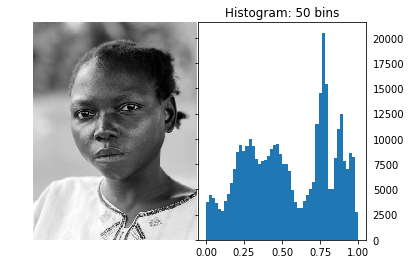

In [115]:
img = AnImage("media/img3.jpeg")
print( img.stats )
img.show(binz=50)

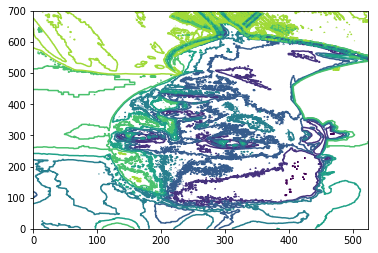

In [116]:
img.contour( ); 

## Geometric Transformations

In [117]:
class GeomTransforms:
    @staticmethod
    def identity(img):
        return img
    
    @staticmethod
    def resize(img, size):
        pass 
    
    @staticmethod
    def crop(img, start_coords, size):
        nr, nc = img.shape 
        x, y = start_coords
        w, h = size 
        outi = img[ x:x+w, y:y+h]
        return outi
    
    @staticmethod
    def flip(img):
        return np.flipud(img)
    
    @staticmethod
    def rotate(img, degrees, reshape=False):
        return ndimage.rotate(img, degrees, reshape=reshape)
    
    

In [118]:
def operate_and_plot(img_array, operationz, nc=2):
    n = len(operationz)
    nr = n//nc + ( 0 if n%nc == 0 else 1) 
    for i, axn in enumerate(operationz):
        plt.subplot(nr, nc, (i+1) )
        plt.imshow( axn[0](img_array, *axn[1:]), cmap='gray')
        plt.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show();

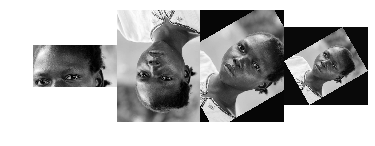

In [119]:
axnz = [ (GeomTransforms.crop, (120,120), (200,500)), 
         (GeomTransforms.flip, ),
         (GeomTransforms.rotate, -60),
         (GeomTransforms.rotate, -60, True)]

operate_and_plot(img.img, axnz, nc=4)

## Image Filtering
**Local Filters**
Update pixels by a function of neighbouring pixels
- box or mean or uniform blur
- maximal value
- median blur
- gaussian


**Morphological Filters**
- Erosion: is min filter, removes objects smaller than the structuring element
- Dilation: is max filter, 
- Opening: = erode + dilate. Removes noise/smoothens 
- Closing: = dilate + erode, 
- Others:
    - hit and miss transform
    - tophat


In [167]:
class SmoothingFilters:
    @staticmethod
    def gaussian(img, kern_sigma):
        ## smoothes out both noise and edges
        return ndimage.gaussian_filter(img, sigma=kern_sigma )
    
    @staticmethod
    def uniform(img, kern_size):
        ## is local linear isotrophic
        return ndimage.uniform_filter(img, size=kern_size)
    
    @staticmethod
    def median(img, kern_size):
        ## has better preservation of edges
        ## better results for straight boundaries/low-curvature
        return ndimage.median_filter(img, kern_size)
    
    @staticmethod
    def max_rank(img, k):
        return ndimage.maximum_filter(img, k)
        
    @staticmethod
    def percentile_rank(img, k):
        return ndimage.percentile_filter(img, k)
    
    ## local non-linear     TODO
    @staticmethod
    def weiner(img, k):
        ## local non-linear @ scipy.signal.weiner 
        return ndimage.maximum_filter(img, k)
    
    
    
class SharpeningFilters:     
    @staticmethod
    def gauss_laplacian(img, k):
        return ndimage.gaussian_laplace(img, k)
    
    
class MorphologicalFilters:
    @staticmethod
    def structuring_element(size):        
        mask = ndimage.generate_binary_structure(*size)
        mask.astype(np.int)
        return mask 
        
    @staticmethod
    def propagate(img, mask):
        return ndimage.binary_propagation(img, mask=mask)
    
    @staticmethod
    def merode(img, size=(2,1)):
        ## a minimum filter. Update pixel by minimum of neighbours covered by structuring element mask
        ## removes objects smaller than the structure
        return ndimage.binary_erosion(img, structure=MorphologicalFilters.structuring_element(size) )
    
    @staticmethod
    def mdilate(img, size=(2,1)):
        return ndimage.binary_dilation(img, structure=MorphologicalFilters.structuring_element(size) )
    
    @staticmethod
    def mopen(img, size=(2,1)):
        return ndimage.binary_opening(img, structure=MorphologicalFilters.structuring_element(size) )    
    
    @staticmethod
    def mclose(img, size=(2,1)):
        return ndimage.binary_closing(img, structure=MorphologicalFilters.structuring_element(size) )

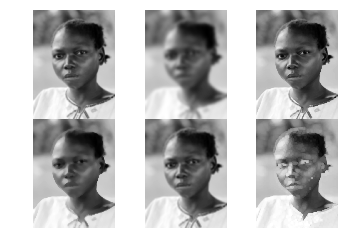

In [168]:
axnz = [
    (SmoothingFilters.gaussian, 3),    
    (SmoothingFilters.gaussian, 9),   
    (SmoothingFilters.median, 9),
    (SmoothingFilters.median, 19),
    (SmoothingFilters.uniform, 13), 
    (SmoothingFilters.max_rank, 13), 
] 

operate_and_plot(img.img, axnz, nc=3)

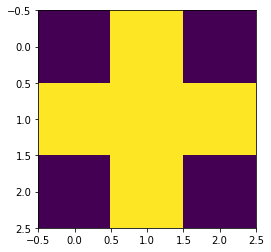

In [169]:
plt.imshow(MorphologicalFilters.structuring_element((2,1)) );

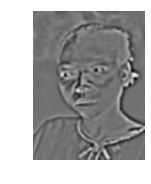

In [170]:
axnz = [ 
    (SharpeningFilters.gauss_laplacian, 7)
] 

operate_and_plot(img.noisy, axnz, nc=3)

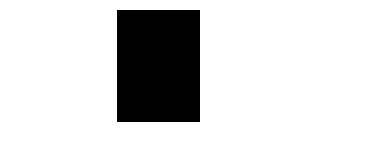

In [171]:
axnz = [ 
    (MorphologicalFilters.merode, (2,1)),
    (MorphologicalFilters.mdilate, (2,1)),
    (MorphologicalFilters.mopen, (2,1)),
    (MorphologicalFilters.mclose, (2,1)),
] 

operate_and_plot(img.noisy, axnz, nc=4)

## Feature Extraction 
- Edge Detection
- Segmentation
    - Histogram-based: global, no spatial information preserved
    - Watershed segmentation (morphological) 
    - binary erode+propagate+reconstruct
- Measuring object properties
    - Connected components, Labeling, Find regions of initerest, 
    - Regions: size:area, , mean, max, center of mass, 
    - Correlations functions, Fourier/wavelet spectrum, 
    
**TODO:**
- `scikit-learn image processing`

In [191]:

class FeatureExtraction:
    @staticmethod
    def sobel_edges(img):
        x = ndimage.sobel(img, axis=0, mode='constant')
        y = ndimage.sobel(img, axis=1, mode='constant')
        return np.hypot(x, y)
    
    @staticmethod
    def hist_segmentation(img, sig=5):
        smoothed = ndimage.gaussian_filter(img, sigma=sig)
        
        mask = ( smoothed > smoothed.mean() ).astype(np.float)
        mask += 0.1* smoothed 
        
        outi = mask + 0.2*np.random.randn(*mask.shape)
        
        hist, bins = np.histogram(img, bins=60)
        
        binary_img= outi > 0.5 
        
        # remove small white regions; fill up black spaces
        open_img = ndimage.binary_opening( binary_img )
        # remove small black holes; fill up white regions 
        close_img = ndimage.binary_closing( open_img)
        
        return close_img
    
    @staticmethod
    def erode_backpropagate_segmentation(img, sig=5):
        smoothed = ndimage.gaussian_filter(img, sigma=sig)
        
        mask = ( smoothed > smoothed.mean() ).astype(np.float)
        mask += 0.1* smoothed 
        
        outi = mask + 0.2*np.random.randn(*mask.shape)
        
        binary_img= outi > 0.5 
        
        # now with erode and backprogate 
        outi = ndimage.binary_erosion( binary_img )
        outi = ndimage.binary_propagation( outi, mask=binary_img)
        
        # and reconstruct 
        tmp = np.logical_not( outi )
        etmp = ndimage.binary_erosion( tmp ) 
        out_outi = np.logical_not(
                    ndimage.binary_propagation( etmp, mask=tmp) )
        
        return out_outi
        

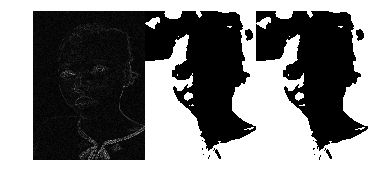

In [192]:
axnz = [ 
    (FeatureExtraction.sobel_edges, ), 
    (FeatureExtraction.hist_segmentation, 3), 
    (FeatureExtraction.erode_backpropagate_segmentation, 3)
] 

operate_and_plot(img.noisy, axnz, nc=3)

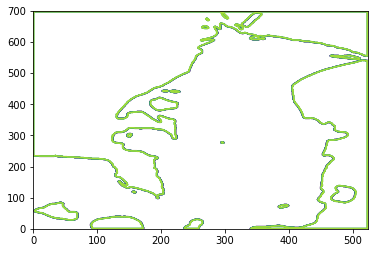

In [190]:
plt.contour( FeatureExtraction.hist_segmentation(img.img, 3) );

In [ ]:
show_image([ndimage.binary_propagation()])